In [11]:
import json
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np




# Plotting functions

In [12]:
def parse_data(runs, metric, compare_on:str):
    '''
    compare_on: "batch_size", "use_batch_norm", None
    '''
    
    data = defaultdict(lambda: defaultdict(list))


    for r in runs:
        act = r["activation_function"]                  
        batch = r["training_parameters"]["batch_size"]  
        if "use_batch_norm" in r:
            use_batch_norm =  r["use_batch_norm"] == 1
        else:
            use_batch_norm = True if runs.index(r) % 2 == 0 else False # pour les runs ou le batch norn n'a pas été enregisté
        acc = r["final_test_loss"][metric]
        
        
        if compare_on == "batch_size":
            data[batch][act].append(acc)
        elif compare_on == "use_batch_norm":
            data[use_batch_norm][act].append(acc)
        else:
            data[" "][act].append(acc)
            
    return data

In [13]:
def plot_boxplot(data, metric, title_end="", x_axis_label="",save_name=None):
    
    batches = sorted(data.keys())       
    width = 0.35                         



    positions = []       
    box_data = []       
    box_colors = []      



    for i, batch in enumerate(batches):
        center = i  



        # position ReLU vs GELU autour du centre
        pos_relu = center - width / 2
        pos_gelu = center + width / 2



        positions.extend([pos_relu, pos_gelu])
        box_data.append(data[batch]["relu"])
        box_data.append(data[batch]["gelu"])
        box_colors.extend(["cornflowerblue", "lightcoral"])
        
    fig, ax = plt.subplots(figsize=(10, 5))
    bp = ax.boxplot(
        box_data,
        positions=positions,
        widths=width,
        patch_artist=True,  # pour pouvoir colorer l'intérieur des boîtes
    )

    for box, color in zip(bp["boxes"], box_colors):
        box.set(facecolor=color)


    ax.yaxis.grid(True, linestyle="--", linewidth=0.5, color="lightgray", alpha=0.7)



    ax.set_xticks(range(len(batches)))
    ax.set_xticklabels([f"{x_axis_label} {b}" for b in batches])

    ax.set_ylabel(metric)
    ax.set_title(metric + " - ReLU vs GELU - test set - " + title_end)



    legend_handles = [
        Patch(facecolor="cornflowerblue", label="ReLU"),
        Patch(facecolor="lightcoral", label="GELU"),
    ]
    ax.legend(handles=legend_handles, loc="lower right")

    plt.tight_layout()
    plt.show()
    if save_name:
        fig.savefig(f"plots/{save_name}_{metric}_{title_end}", dpi=300)

In [14]:
def plot_every_comparison(runs, metric, save_name=None):
    # plot les boxplot pour chaque comparaison étudiée 
    data = parse_data(runs, metric, "batch_size")
    plot_boxplot(data, metric, title_end= 'by batch size', x_axis_label= 'batch size :', save_name= save_name)
    data = parse_data(runs, metric, "use_batch_norm")
    plot_boxplot(data, metric, title_end= 'by batch norm', x_axis_label= 'batch norm :', save_name= save_name)
    data = parse_data(runs, metric, None)
    plot_boxplot(data, metric, title_end= '', x_axis_label= " ", save_name= save_name)


In [15]:

def plot_overfitting_compare(runs,save_name=None):
    COLOR_RELU = "cornflowerblue"  
    COLOR_GELU =  "lightcoral" 

    generalization_gap = {"relu": [], "gelu": []}
    overfit_score = {"relu": [], "gelu": []}

    for r in runs:
        act = r["activation_function"].lower()   
        if act not in generalization_gap:
            continue

        train = np.array(r["train_loss"])
        val = np.array(r["val_loss"])

        # sécurité
        if len(train) == 0 or len(val) == 0:
            continue

        train_final = train[-1]
        val_final = val[-1]
        gap = float(val_final - train_final)
        generalization_gap[act].append(gap)

        best_val = float(val.min())
        overfit = float(val_final - best_val)  # > 0 => la val a remonté
        overfit_score[act].append(overfit)

    # print("Generalization gap (ReLU) :", generalization_gap["relu"])
    # print("Generalization gap (GELU) :", generalization_gap["gelu"])
    # print("Overfitting score (ReLU)  :", overfit_score["relu"])
    # print("Overfitting score (GELU)  :", overfit_score["gelu"])


    data_gap = [generalization_gap["relu"], generalization_gap["gelu"]]
    labels = ["ReLU", "GELU"]
    colors = [COLOR_RELU, COLOR_GELU]

    fig1, ax1 = plt.subplots(figsize=(6, 4))

    bp1 = ax1.boxplot(
        data_gap,
        patch_artist=True,
    )

    for i, box in enumerate(bp1["boxes"]):
        box.set(facecolor=colors[i], edgecolor="black",
                linewidth=1.3, alpha=0.8)

    for median in bp1["medians"]:
        median.set(color="black", linewidth=1.3)
    for whisker in bp1["whiskers"]:
        whisker.set(color="black", linewidth=1.0)
    for cap in bp1["caps"]:
        cap.set(color="black", linewidth=1.0)
    for flier in bp1["fliers"]:
        flier.set(markeredgecolor="black", markerfacecolor="white",
                markersize=4)

    ax1.set_xticklabels(labels)
    ax1.set_ylabel("Generalization gap\n(val_final - train_final)")
    ax1.set_title("Comparaison de l'overfitting (gap final)")
    ax1.yaxis.grid(True, linestyle="--", linewidth=0.4,
                color="lightgray", alpha=0.6)


    legend_handles = [
        Patch(facecolor=COLOR_RELU, label="ReLU"),
        Patch(facecolor=COLOR_GELU, label="GELU"),
    ]
    ax1.legend(handles=legend_handles, loc="lower right",
            )


    plt.tight_layout()
    plt.show()

    if save_name:
        fig1.savefig(f"plots/{save_name}_generalization_gap", dpi=300)

    data_overfit = [overfit_score["relu"], overfit_score["gelu"]]


    fig2, ax2 = plt.subplots(figsize=(6, 4))


    bp2 = ax2.boxplot(
        data_overfit,
        patch_artist=True,
    )
    for i, box in enumerate(bp2["boxes"]):
        box.set(facecolor=colors[i], edgecolor="black",
                linewidth=1.3, alpha=0.8)
    for median in bp2["medians"]:
        median.set(color="black", linewidth=1.3)
    for whisker in bp2["whiskers"]:
        whisker.set(color="black", linewidth=1.0)
    for cap in bp2["caps"]:
        cap.set(color="black", linewidth=1.0)
    for flier in bp2["fliers"]:
        flier.set(markeredgecolor="black", markerfacecolor="white",
                markersize=4)
    ax2.set_xticklabels(labels)
    ax2.set_ylabel("Overfitting score\n(val_final - min(val))")
    ax2.set_title("Remontée de la validation loss (surapprentissage)")
    ax2.yaxis.grid(True, linestyle="--", linewidth=0.4,
                color="lightgray", alpha=0.6)
    ax2.legend(handles=legend_handles, loc="lower right",
            )
    plt.tight_layout()
    plt.show()
    if save_name:
        fig2.savefig(f"plots/{save_name}_overfitting_score", dpi=300)

In [16]:
def plot_speed_convergence(runs, TOL = 0.05,save_name=None):
    # couleurs pastel cohérentes partout
    COLOR_RELU = "cornflowerblue"  
    COLOR_GELU =  "lightcoral" 

    conv_epochs = {"relu": [], "gelu": []}
    relu_curves = []
    gelu_curves = []
    for r in runs:
        act = r["activation_function"].lower()   
        val_loss = np.array(r["val_loss"])
        # stocker la courbe pour la partie "moyenne"
        if act == "relu":
            relu_curves.append(val_loss)
        elif act == "gelu":
            gelu_curves.append(val_loss)
        # calcul de l'époque de convergence 
        if len(val_loss) == 0 or act not in conv_epochs:
            continue
        best = val_loss.min()
        thresh = best * (1 + TOL)
        # première époque où val_loss <= seuil
        idx_candidates = np.where(val_loss <= thresh)[0]
        if len(idx_candidates) == 0:
            # si jamais ça n'atteint jamais le seuil, on prend la dernière époque
            epoch = len(val_loss)
        else:
            epoch = int(idx_candidates[0]) + 1  # epochs en 1-based
        conv_epochs[act].append(epoch)
    # print("Époques de convergence (ReLU) :", conv_epochs["relu"])
    # print("Époques de convergence (GELU) :", conv_epochs["gelu"])



    data_box = [conv_epochs["relu"], conv_epochs["gelu"]]
    labels_box = ["ReLU", "GELU"]
    colors_box = [COLOR_RELU, COLOR_GELU]
    fig1, ax1 = plt.subplots(figsize=(6, 4))
    bp = ax1.boxplot(
        data_box,
        patch_artist=True,
    )

    for i, box in enumerate(bp["boxes"]):
        box.set(facecolor=colors_box[i], edgecolor="black",
                linewidth=1.3, alpha=0.8)
    for median in bp["medians"]:
        median.set(color="black", linewidth=1.3)
    for whisker in bp["whiskers"]:
        whisker.set(color="black", linewidth=1.0)
    for cap in bp["caps"]:
        cap.set(color="black", linewidth=1.0)
    for flier in bp["fliers"]:
        flier.set(markeredgecolor="black", markerfacecolor="white",
                markersize=4)
    ax1.set_xticklabels(labels_box)
    ax1.set_ylabel("Époque de convergence (val_loss)")
    ax1.set_title(f"Vitesse de convergence (tolérance {int(TOL*100)}%)")
    ax1.yaxis.grid(True, linestyle="--", linewidth=0.4,
                color="lightgray", alpha=0.6)
    legend_handles = [
        Patch(facecolor=COLOR_RELU, label="ReLU"),
        Patch(facecolor=COLOR_GELU, label="GELU"),
    ]
    ax1.legend(handles=legend_handles, loc="lower right",
            title="Activation")
    plt.tight_layout()
    plt.show()
    if save_name:
        fig1.savefig(f"plots/{save_name}_convergence_speed", dpi=300)


    relu_curves = [np.array(c) for c in relu_curves]
    gelu_curves = [np.array(c) for c in gelu_curves]
    if len(relu_curves) > 0:
        relu_mean = np.mean(relu_curves, axis=0)
        relu_std = np.std(relu_curves, axis=0)
    else:
        relu_mean = relu_std = None
    if len(gelu_curves) > 0:
        gelu_mean = np.mean(gelu_curves, axis=0)
        gelu_std = np.std(gelu_curves, axis=0)
    else:
        gelu_mean = gelu_std = None
    # on suppose que toutes les courbes ont la même longueur
    n_epochs = len(relu_curves[0]) if len(relu_curves) > 0 else len(gelu_curves[0])
    epochs = np.arange(1, n_epochs + 1)
    fig2, ax2 = plt.subplots(figsize=(8, 4))
    if relu_mean is not None:
        ax2.plot(epochs, relu_mean, label="ReLU", color=COLOR_RELU)
        ax2.fill_between(epochs, relu_mean - relu_std, relu_mean + relu_std,
                        color=COLOR_RELU, alpha=0.2)
    if gelu_mean is not None:
        ax2.plot(epochs, gelu_mean, label="GELU", color=COLOR_GELU)
        ax2.fill_between(epochs, gelu_mean - gelu_std, gelu_mean + gelu_std,
                        color=COLOR_GELU, alpha=0.2)
    ax2.set_xlabel("Époques")
    ax2.set_ylabel("Validation loss")
    ax2.set_title("Courbes moyennes de validation loss")
    ax2.yaxis.grid(True, linestyle="--", linewidth=0.4,
                color="lightgray", alpha=0.6)
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
    if save_name:
        fig2.savefig(f"plots/{save_name}_val_loss_curves", dpi=300)

# Brevage price forcasting

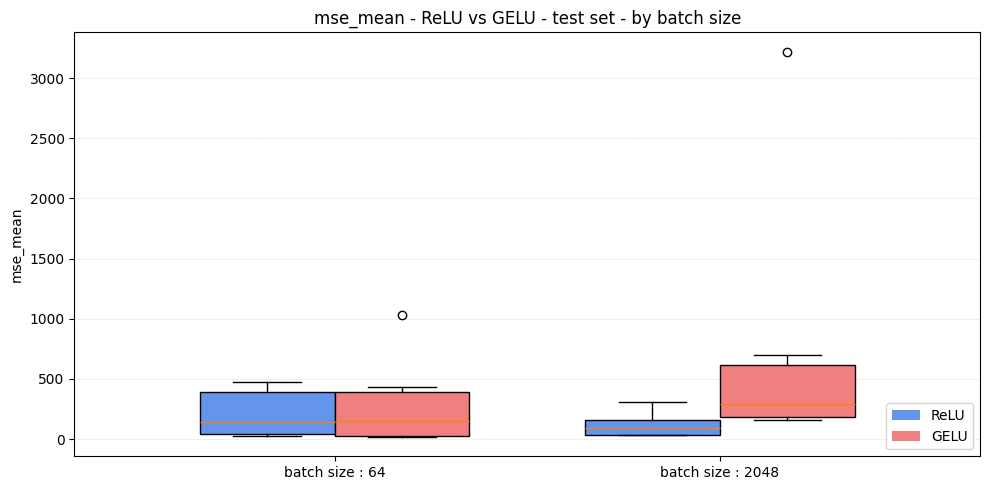

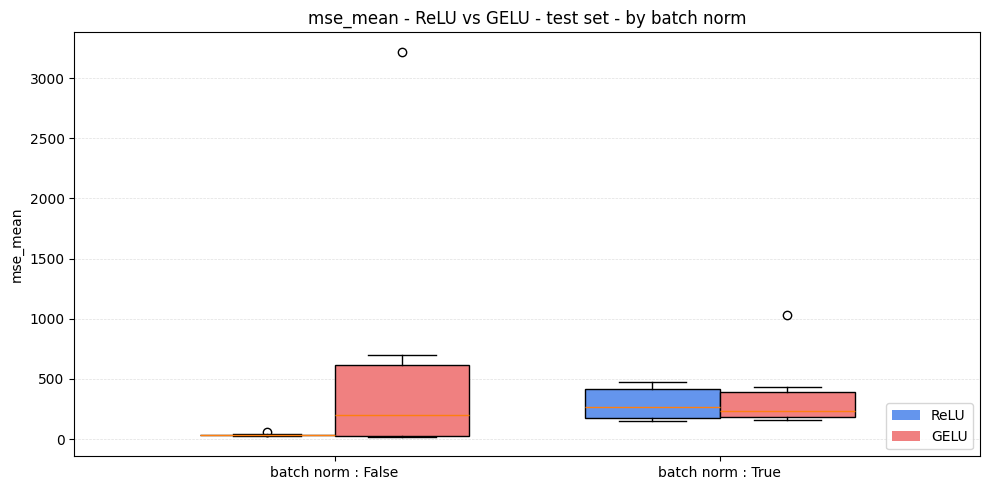

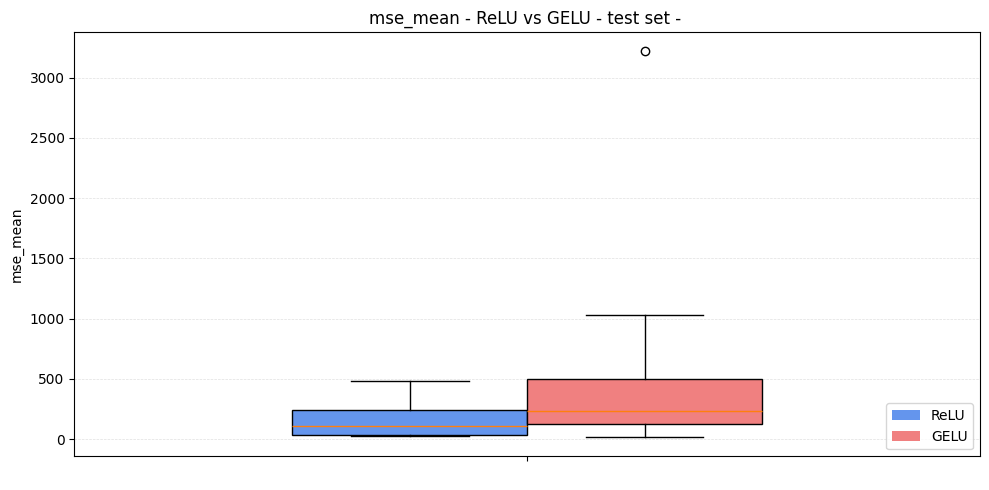

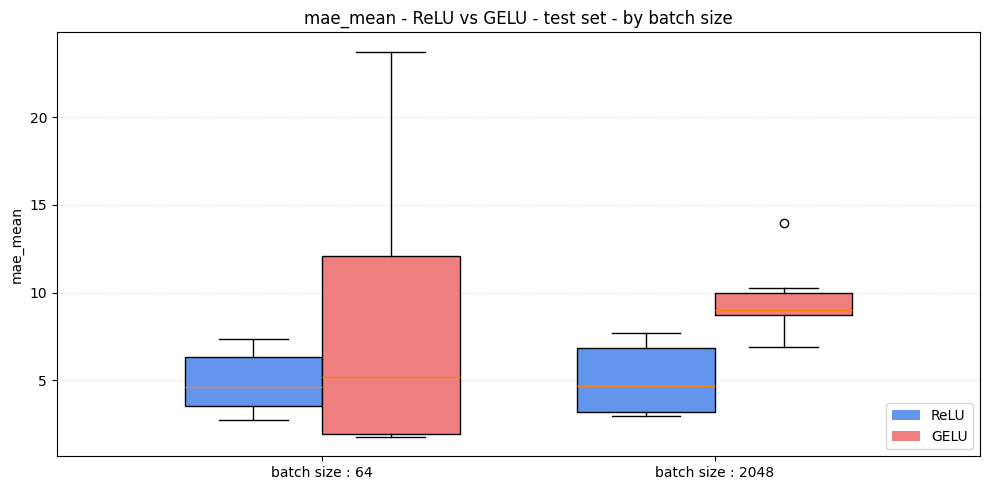

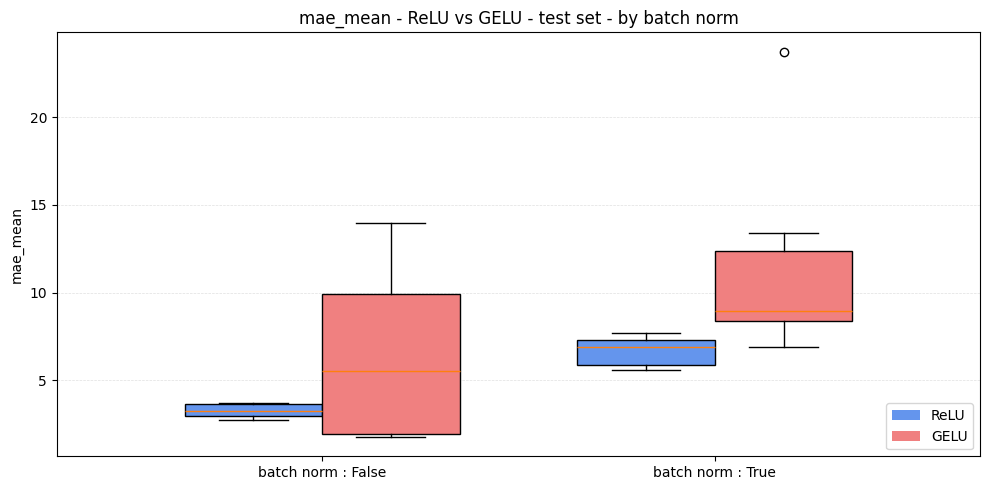

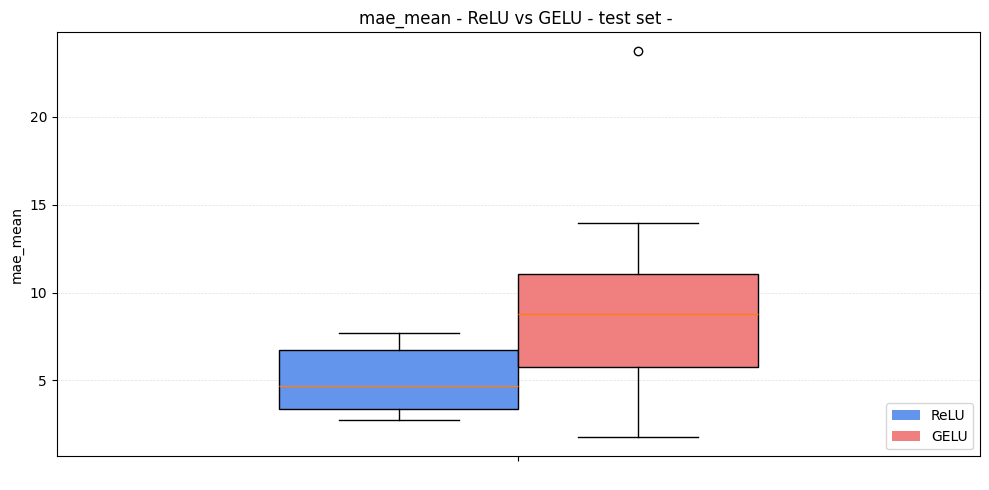

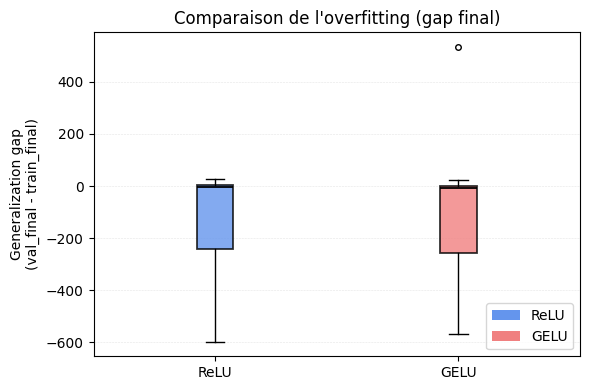

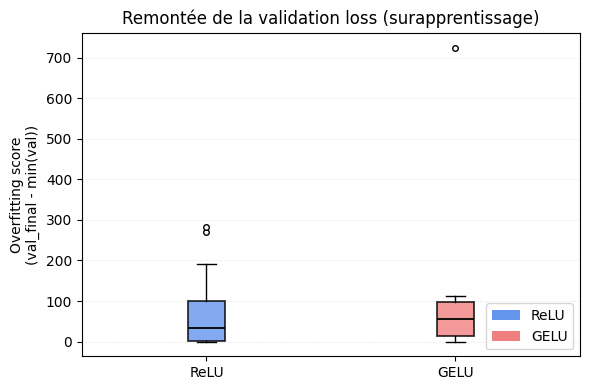

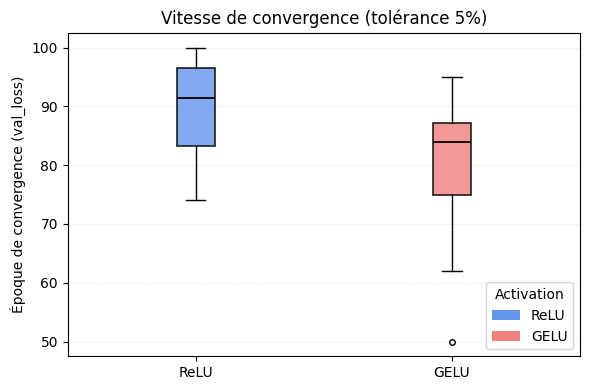

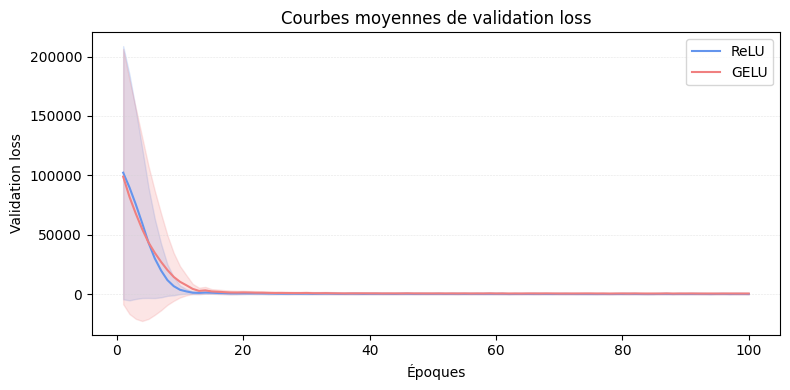

In [17]:
with open("results/brevage_histories.json", "r") as f:
    runs = json.load(f)



metric = "mse_mean"  
plot_every_comparison(runs, metric, save_name='brevage')

metric = "mae_mean"
plot_every_comparison(runs, metric, save_name='brevage')

plot_overfitting_compare(runs, save_name='brevage')
plot_speed_convergence(runs, save_name='brevage')

# Animals prediction

Pas de visualisation car l'entrainement de ce modèle était trop long 

# MNIST Digit Detection


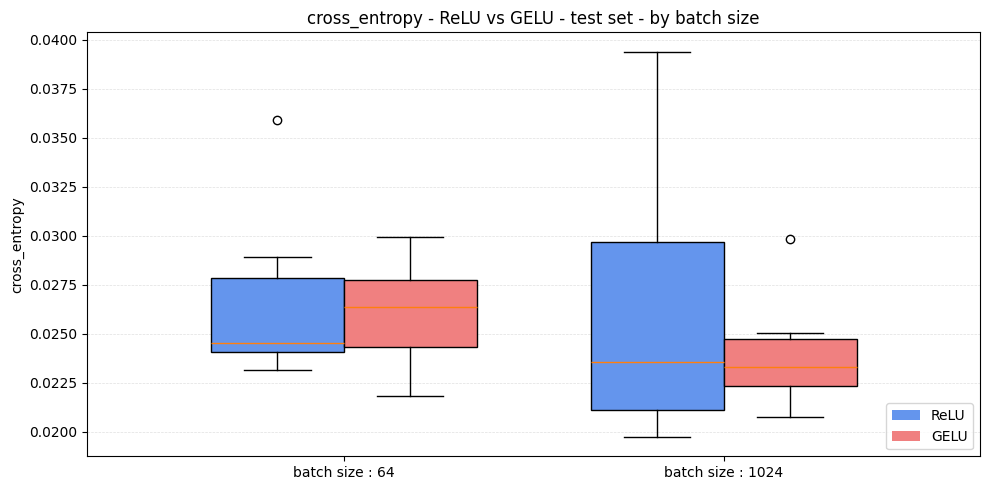

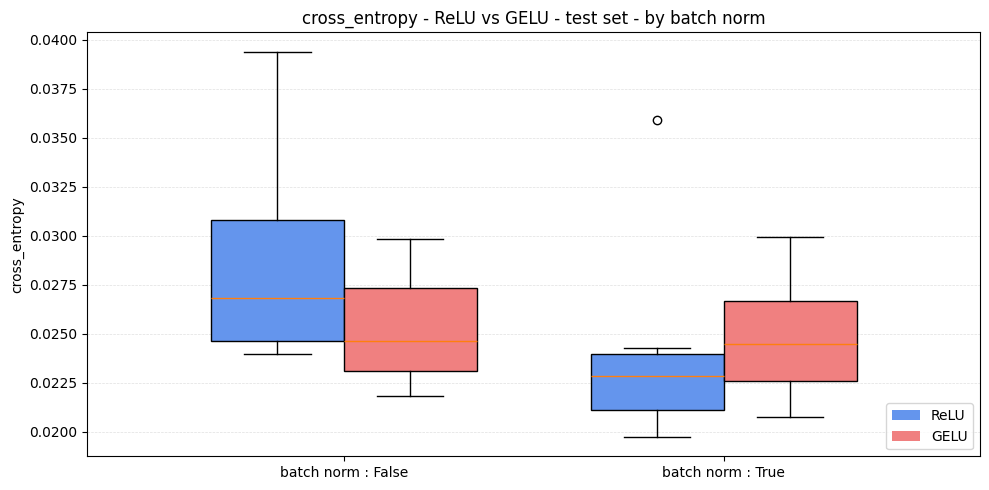

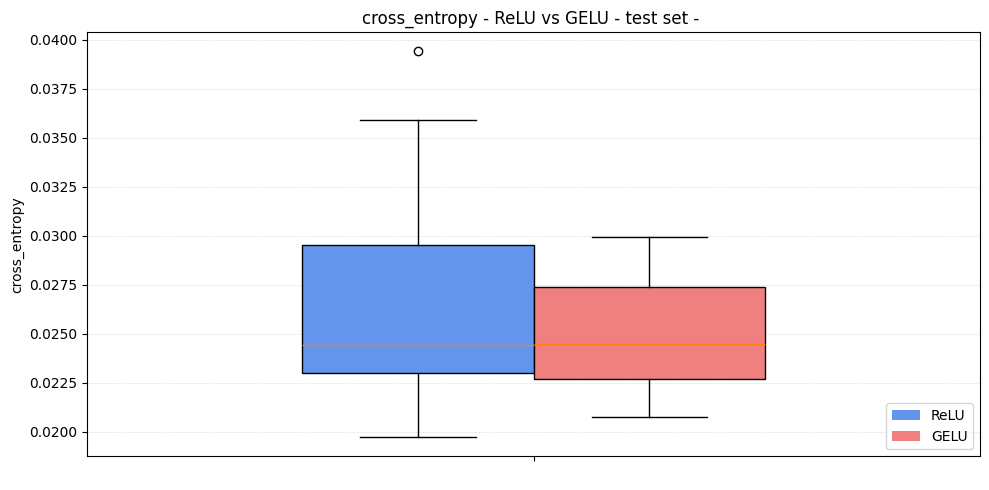

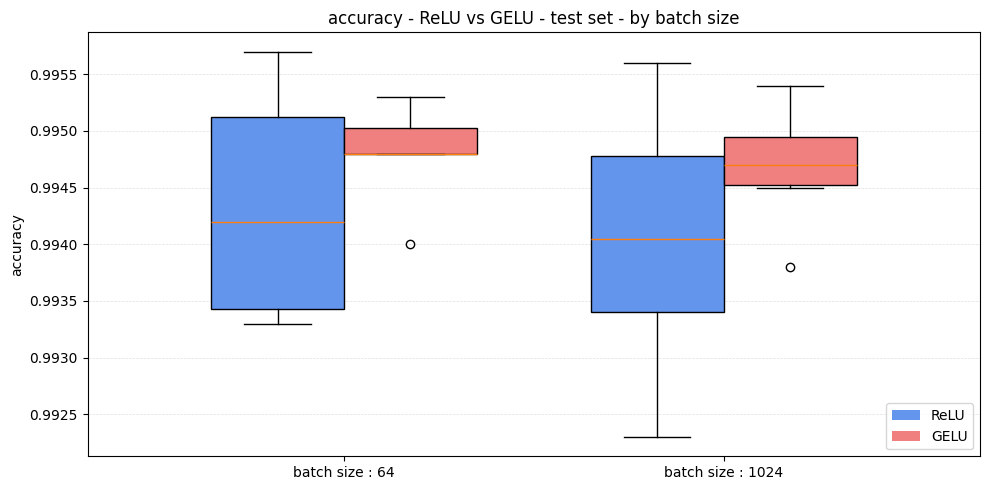

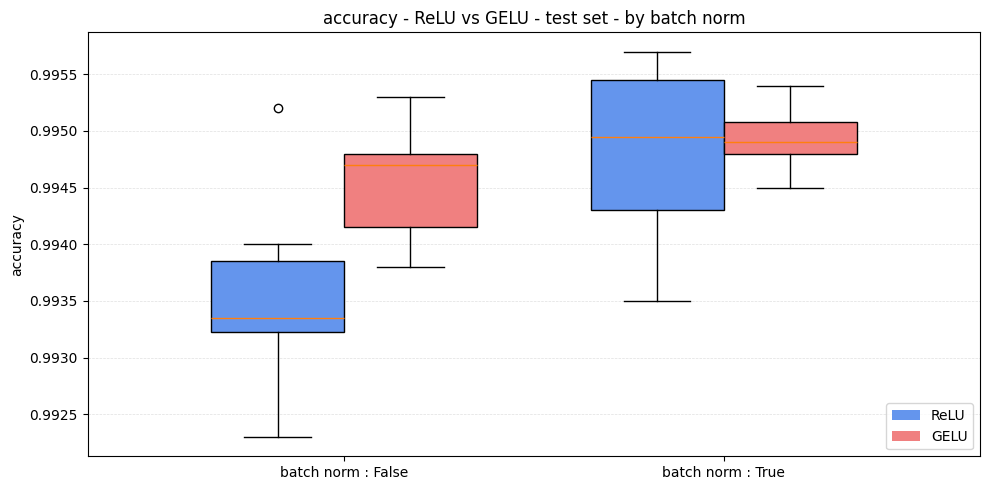

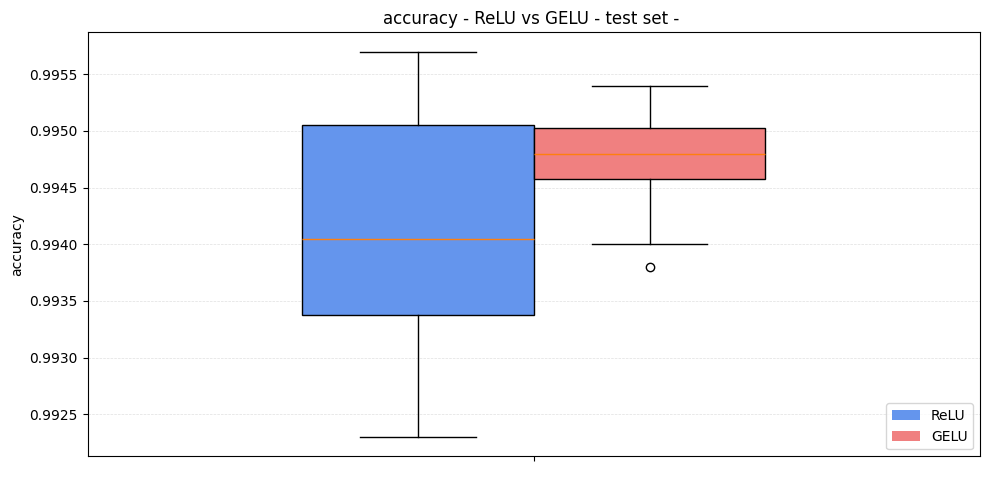

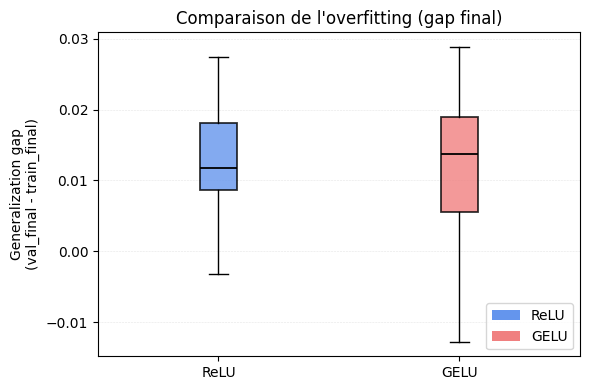

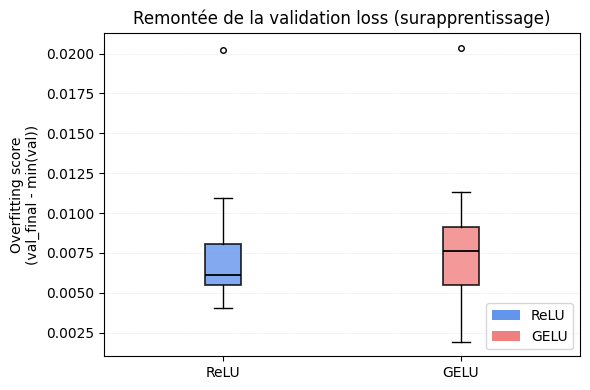

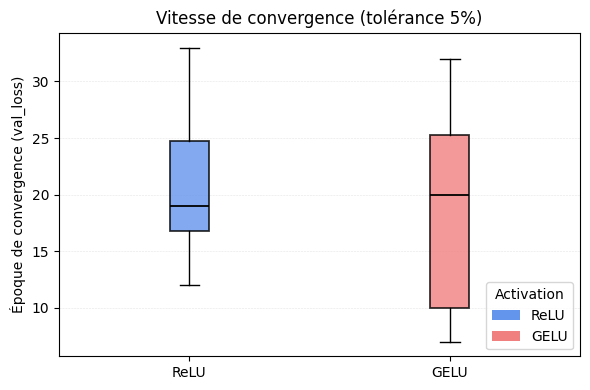

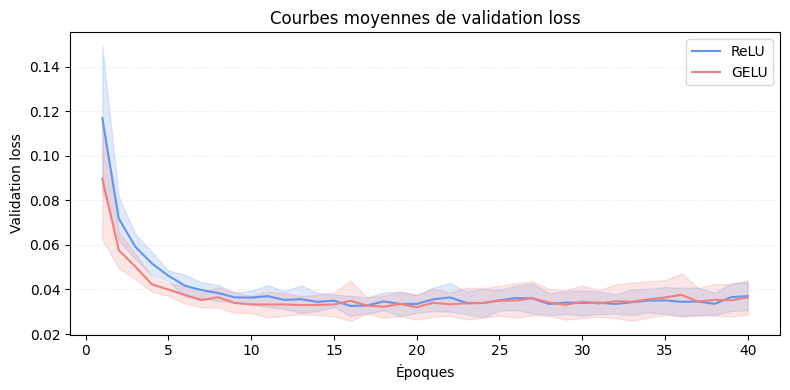

In [18]:

with open("results/mnist_histories.json", "r") as f:
    runs = json.load(f)



metric = "cross_entropy"  
plot_every_comparison(runs, metric, save_name='MNIST')

metric = "accuracy"
plot_every_comparison(runs, metric, save_name='MNIST')

plot_overfitting_compare(runs, save_name='MNIST')
plot_speed_convergence(runs, save_name='MNIST')

# Student Grade Forcasting

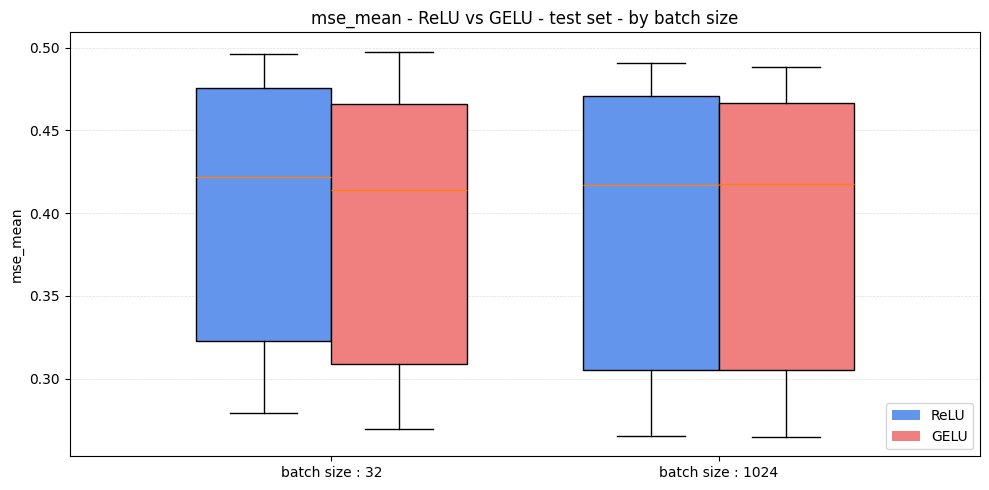

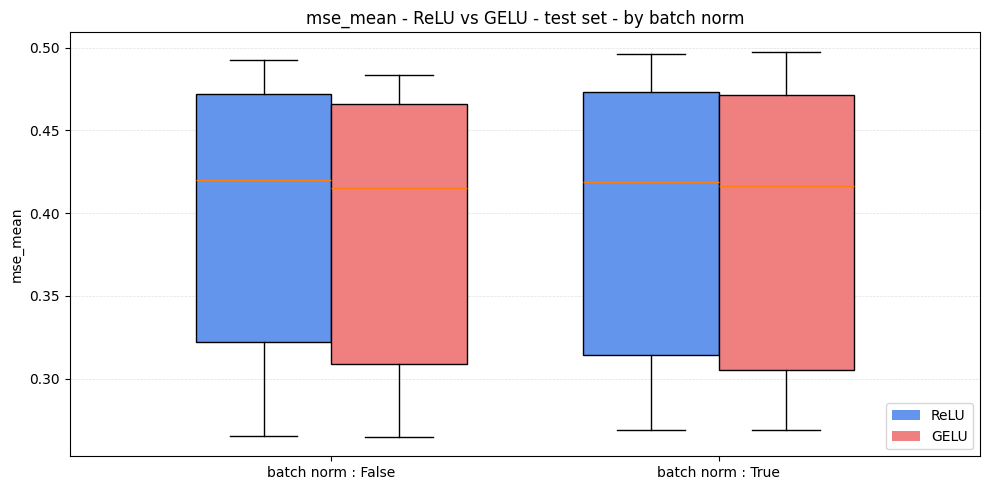

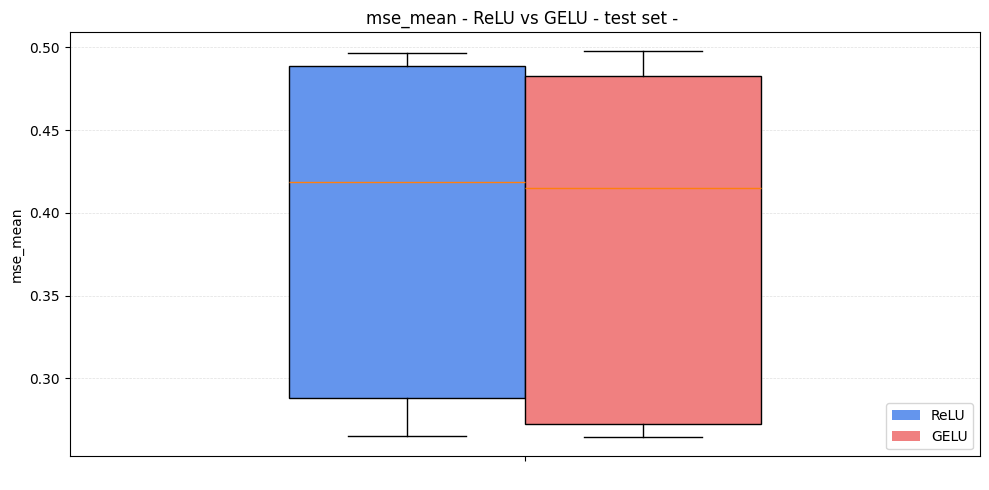

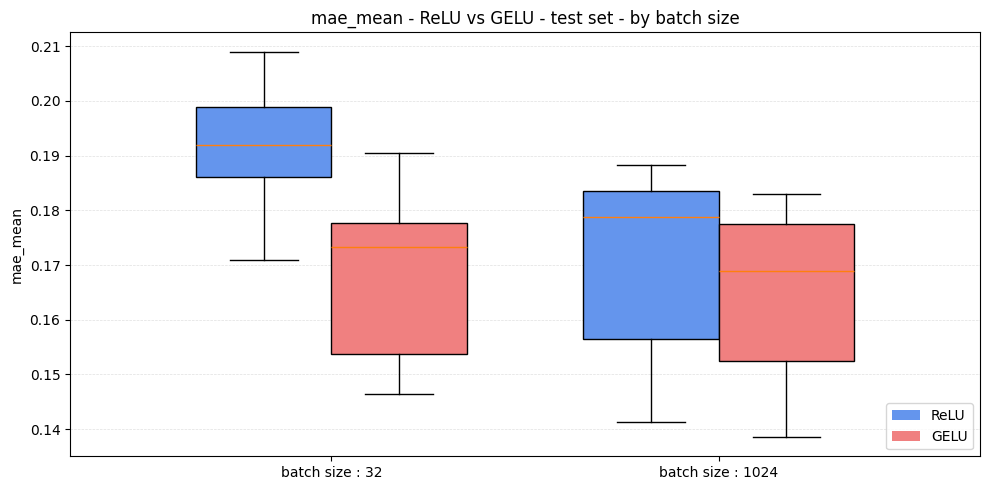

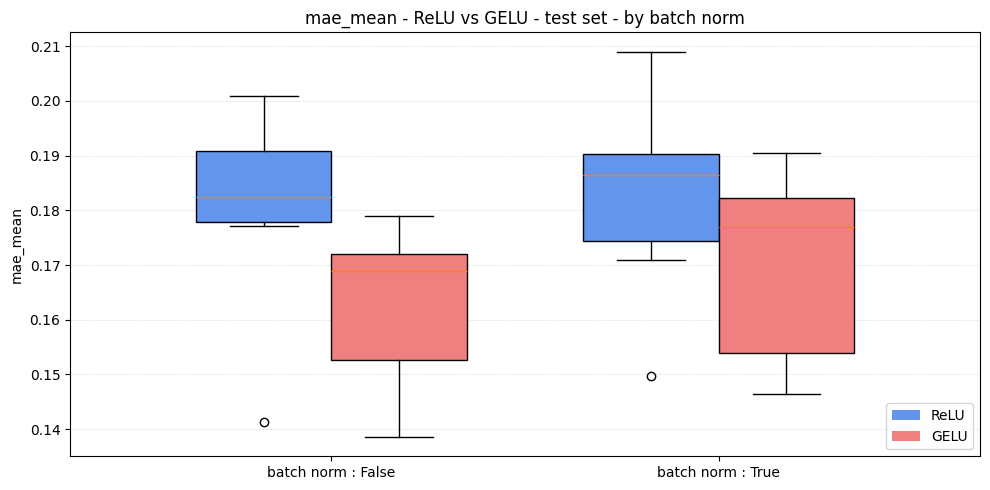

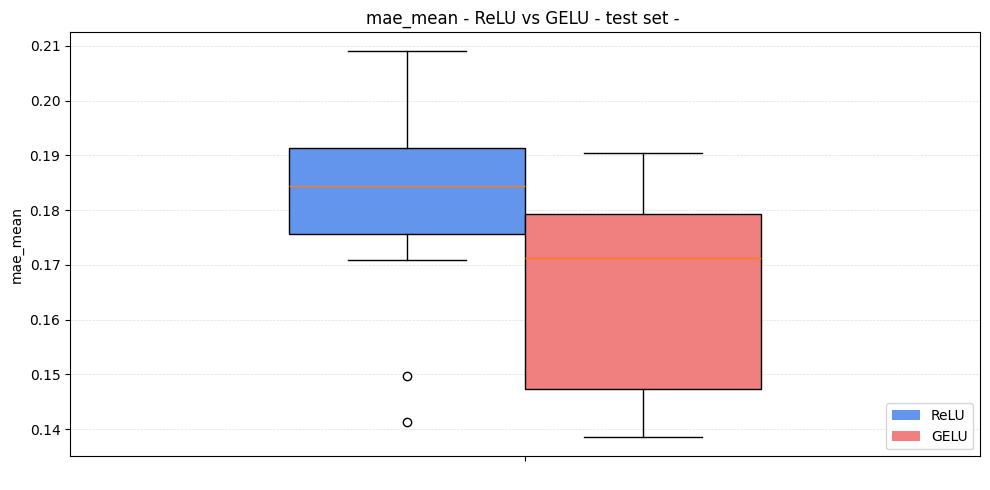

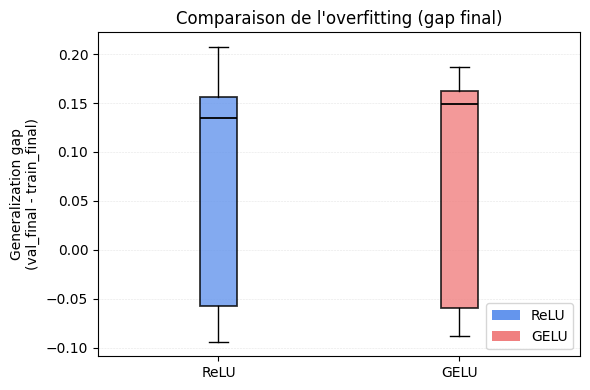

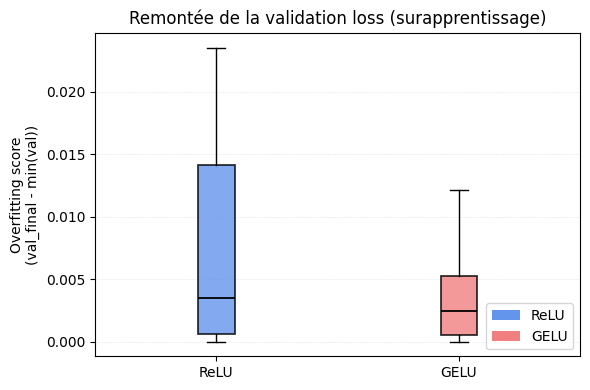

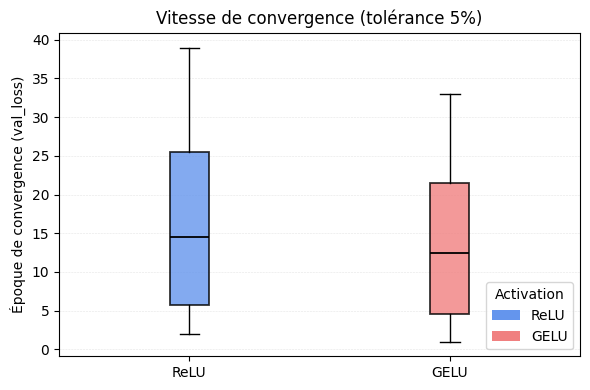

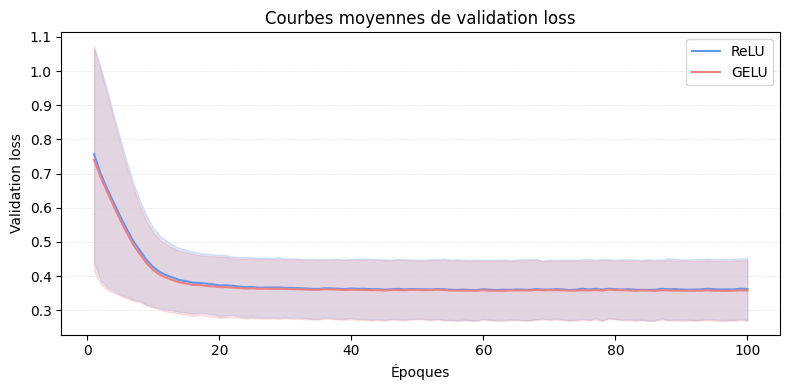

In [19]:

with open("results/student_histories.json", "r") as f:
    runs = json.load(f)



metric = "mse_mean"  
plot_every_comparison(runs, metric, save_name='Student')

metric = "mae_mean"
plot_every_comparison(runs, metric, save_name='Student')

plot_overfitting_compare(runs, save_name='Student')
plot_speed_convergence(runs, save_name='Student')

# Food price inflation

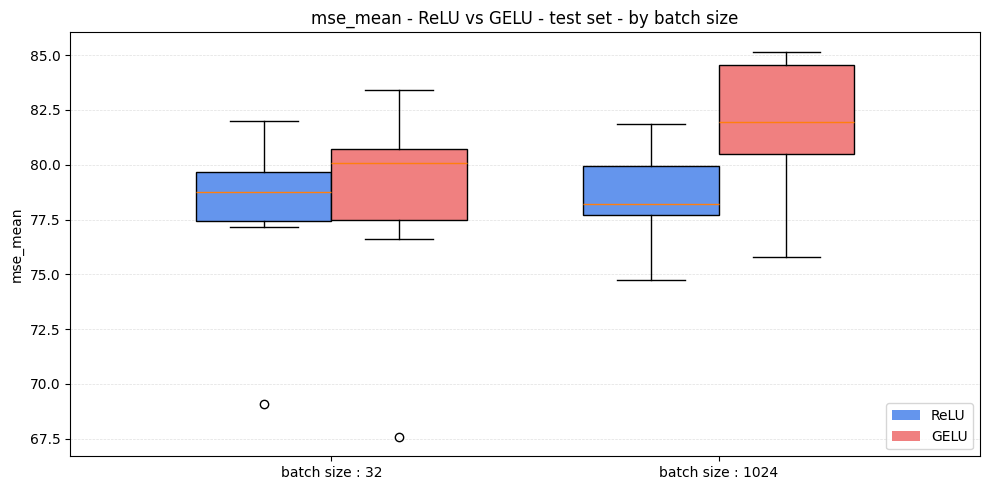

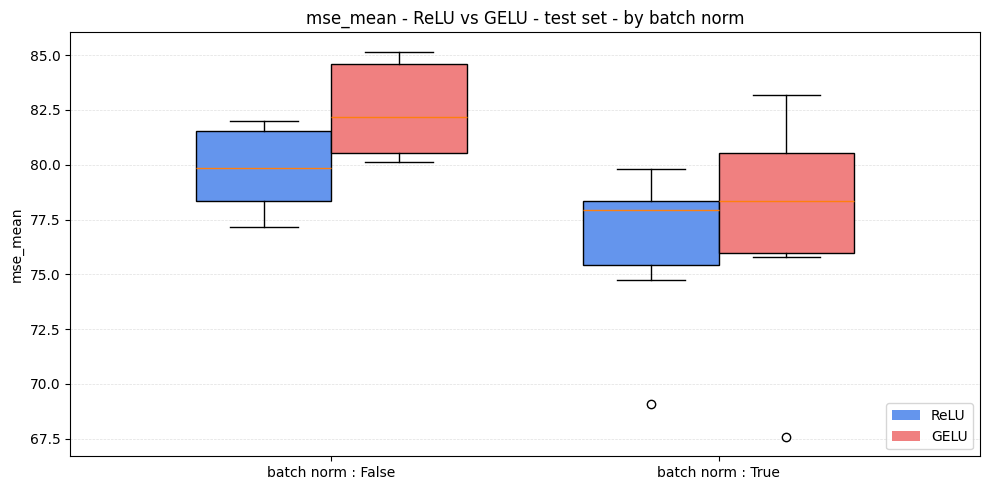

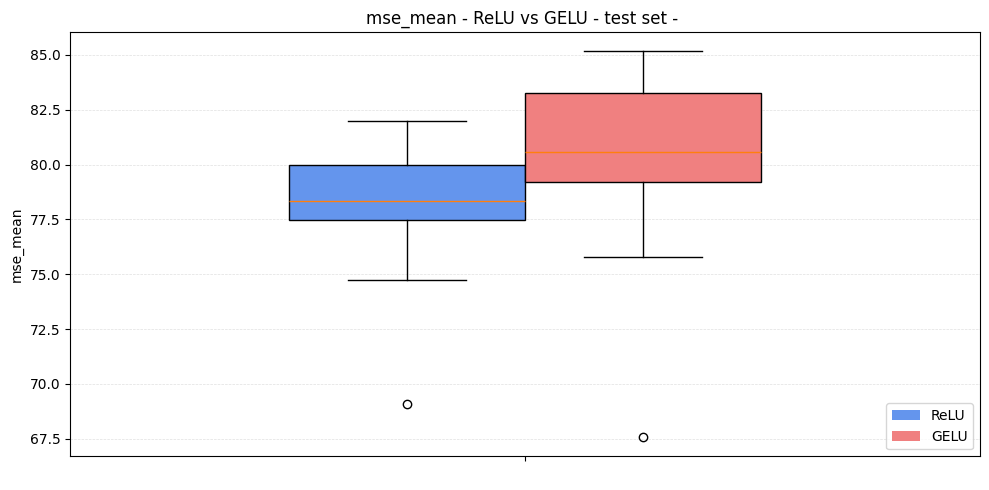

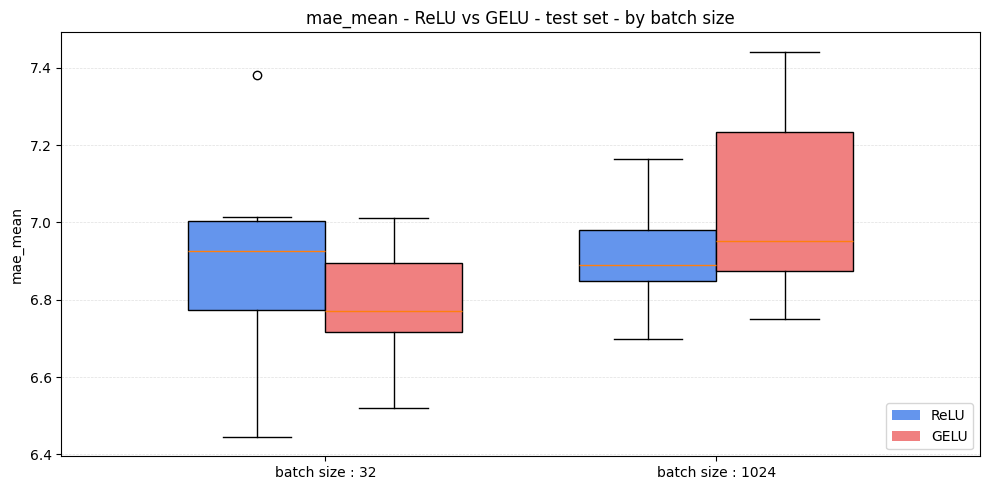

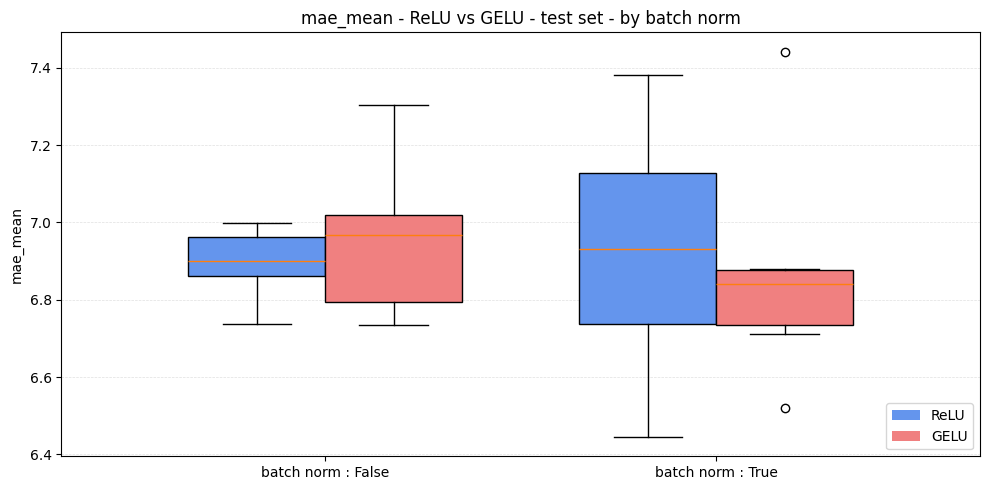

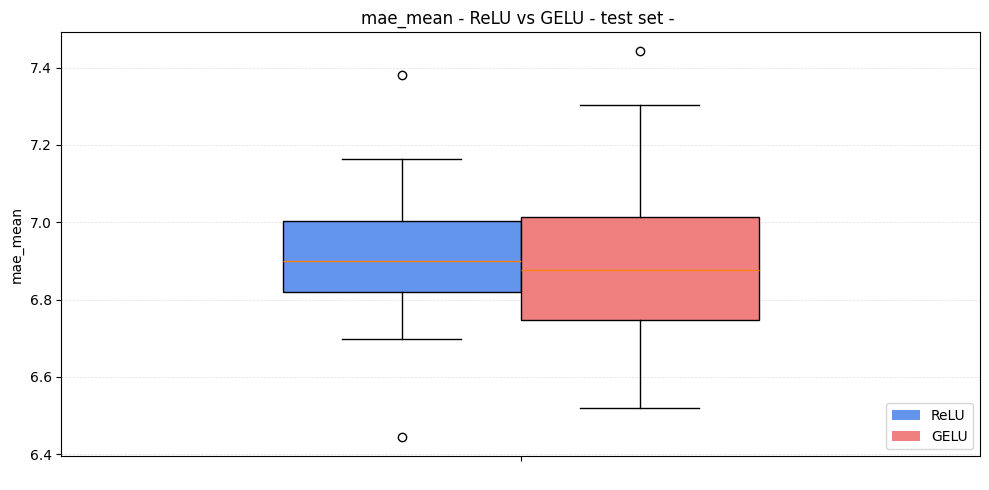

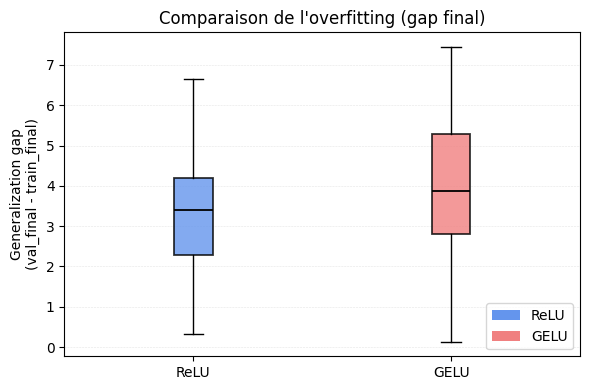

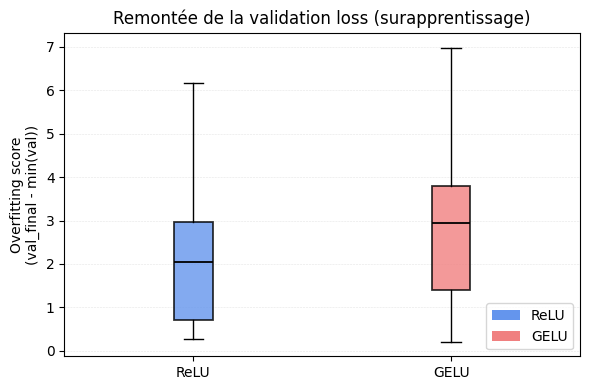

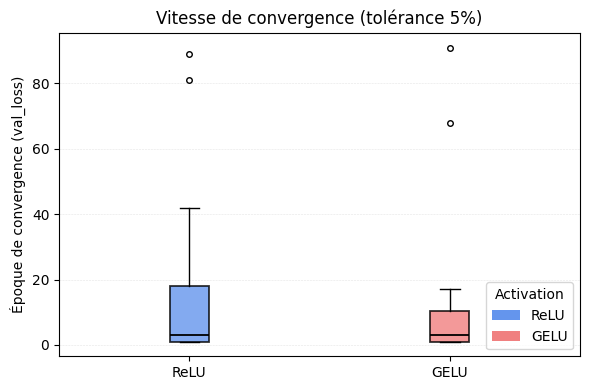

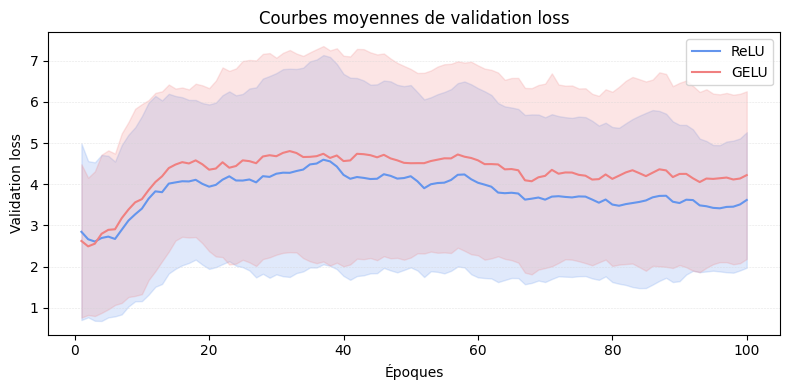

In [20]:
with open("results/food_price_histories.json", "r") as f:
    runs = json.load(f)



metric = "mse_mean"  
plot_every_comparison(runs, metric, save_name='Food_Price')

metric = "mae_mean"
plot_every_comparison(runs, metric, save_name='Food_Price')

plot_overfitting_compare(runs, save_name='Food_Price')
plot_speed_convergence(runs, save_name='Food_Price')